In [1]:
import seaborn as sns
import numpy as np
import scipy as sp
import pandas as pd

# good default imports 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore') 
%matplotlib inline

import pylab 
pylab.rcParams['figure.figsize'] = 10, 7

In [2]:
import collections
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import time

In [3]:
import sys
sys.path.append(".")
import sudoku
# https://phabricator.intern.facebook.com/P59410965

In [4]:
# helper functions converting between a sudoku board and a 1 hot encoded version
# 9x9 matrix where each cell can take 1-9 values becomes a 1 dimensional array of size 9x9x9
def matrix_to_one_hot(m):
    '''Make a 1-hot encoded version of an input sudoku matrix'''
    ret = np.zeros((9,9*9), dtype=int)
    
    mtx = m.flatten()
    
    for v in range(9):
        
        index = mtx==(v+1)
        
        ret[v][index] = 1
        
    return ret.reshape(9*9*9)


def one_hot_to_matrix(oh):
    '''Make convert a one hot encoded sudoku matrix into a sudoku 
    matrix'''
    ret = np.zeros(81, dtype=int)
    
    mtx = oh.reshape((9, 9*9))
    
    for v in range(9):   
        ret[mtx[v]==1] = v+1
    
    return ret.reshape(9,9)

In [5]:
# load puzzles from disk
def get_x_y(f, batches=1):
    '''Read cached sudoku puzzles/answers from disk. Convert them to 1 hot encoded versions'''
    
    if f.closed:
        return [] ,[]
    
    retx = []
    rety = []
    for _ in range(batches):
        line = f.readline()
        
        if f.closed:
            break
        
        xx, yy = line.strip().split(',')

        xx = np.array([int(v) for v in xx]).reshape((9,9))
        yy = np.array([int(v) for v in yy]).reshape((9,9))

        retx.append(xx)
        rety.append(yy)
        
        
    x = list([matrix_to_one_hot(v) for v in retx])

    y = list([matrix_to_one_hot(v) for v in rety])
    
    return x, y

In [6]:
file_name = 'kaggle_sudoku.csv'
#eval_file_name = 'sudoku_eval.dat'

In [7]:
1

1

In [8]:
with open(file_name, 'r') as f:
    puz_x, puz_y = get_x_y(f, batches=1)

input_size = len(puz_x[0])
output_size = len(puz_y[0])

# based on literature
hidden_size = int(output_size + (2. / 3. * input_size) * 1.5) 

print(input_size)
print(output_size)
print(hidden_size)

729
729
1458


In [9]:



def predict(puz, model, is_only_blanks=True):
    model.eval()
    predictions = model(Variable(torch.Tensor([puz])))
    predictions = predictions[0]
    
    predictions = F.softmax(predictions.reshape((9, 81)), dim=0)
    predictions = predictions.reshape(9*81)
    
    predictions = np.array(predictions.tolist())
    min_pred = predictions.min() - 1
    
    if is_only_blanks:
        for i, e in enumerate(puz != 0):
            if e:
                predictions[i] = min_pred
                curr = i
                curr += 81
                while curr % 729 != i:
                    predictions[curr % 729] = min_pred
                    curr += 81  
        
    return predictions
    
def predict_best(puz, model):    
    predictions = predict(puz, model)
    
    ret = np.zeros(81*9, dtype=int)
        
    ret[np.argmax(predictions)] = 1  
    
    return ret


def predict_puzzle(puzzle, model):
    
    num_zeros = np.sum(puzzle == 0)
    r = matrix_to_one_hot(puzzle)
    for _ in range(num_zeros):
        pred = predict_best(r, model)
        
        r = pred + r
        
    r = one_hot_to_matrix(r)
    return r


def accuracy(answer, puzzle, prediction):
    num_zeros = np.sum(puzzle == 0)
    return ((prediction == answer).sum() - (81 - num_zeros)) / num_zeros


In [10]:
class LogisticRegression(torch.nn.Module):
    def __init__(self):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(LogisticRegression, self).__init__()
        self.input_size = 9**3
        self.output_size = 9**3      
        
        self.combined_linear = torch.nn.Linear(input_size, output_size)

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """       
        y_pred = self.combined_linear(x)  
        
        return y_pred
    
    def __str__(self):
        return '{} {} {}'.format(
            type(self).__name__, 
            self.input_size, 
            self.output_size)

In [11]:
def get_tensors(x, y):
    #tensor_x = Variable(torch.Tensor(x))
    #tensor_y = Variable(torch.Tensor(y), requires_grad=False)   
    #return tensor_x, tensor_y    
    x = torch.Tensor(x)
    tensor_x = Variable(x)
    y = torch.Tensor(y)
    tensor_y = Variable(y, requires_grad=False)
    
    
    target = x.reshape(-1, 9, 81).sum(1)==0
    target = target.repeat(1, 9).reshape(-1, 9, 81).reshape(-1, 9*81)
    
    return tensor_x, tensor_y, target




In [12]:
def run_training(file_name, model, num_examples, epochs, batch_size):
    t0 = time.time()
    learning_rate = 0.001
    
    m_name = str(model) + ' {} {}'.format(epochs, batch_size)

    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    #learning_rate = 0.5
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    loss_fn = torch.nn.MultiLabelSoftMarginLoss(reduce=False)

    
    loss_results = []
    time_results = []
    
    def get_file_tensors(f, is_soft_loss, batch_size):
        x, y = get_x_y(f, batches=batch_size)
        return get_tensors(x, y)

    for epoch in range(epochs):
        
        with open(file_name, 'r') as f:
            test_x, test_y, test_target = get_file_tensors(f, True, 400)

            for t in range(int(num_examples/batch_size)):

                if t % 500 == 1:
                    model.eval()
                    # Forward pass: compute predicted y by passing x to the model.
                    y_pred = model(test_x)

                    # Compute and print loss.
                    loss = loss_fn(y_pred, test_y)
                    loss = loss * test_target.type(torch.FloatTensor)
                    #print('test error\t', t, '\t', loss.data[0].tolist())
                    loss_results.append(loss.sum().data[0].tolist())
                    time_results.append(int(time.time() - t0))


                else:
                    model.train()
                    # Before the backward pass, use the optimizer object to zero all of the
                    # gradients for the variables it will update (which are the learnable
                    # weights of the model). This is because by default, gradients are
                    # accumulated in buffers( i.e, not overwritten) whenever .backward()
                    # is called. Checkout docs of torch.autograd.backward for more details.
                    optimizer.zero_grad()
                    
                    x, y, target = get_file_tensors(f, True, batch_size)
                    
                    if len(x) == 0:
                        break
                    
                    # Forward pass: compute predicted y by passing x to the model.
                    y_pred = model(x)

                    # Compute and print loss.
                    loss = loss_fn(y_pred, y)
                    loss = loss * target.type(torch.FloatTensor)
                    # Backward pass: compute gradient of the loss with respect to model
                    # parameters
                    loss = loss.sum() / target.type(torch.FloatTensor).sum()
                    loss.backward()

                    # Calling the step function on an Optimizer makes an update to its
                    # parameters
                    optimizer.step()
    
    return (m_name, loss_results, time_results, model)

In [13]:
import torch.nn.functional as F

import torch
import torch.nn as nn

class ListModule(nn.Module):
    def __init__(self, *args):
        super(ListModule, self).__init__()
        idx = 0
        for module in args:
            self.add_module(str(idx), module)
            idx += 1

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        return iter(self._modules.values())

    def __len__(self):
        return len(self._modules)

class ConvNet(torch.nn.Module):
    def __init__(self, num_layers, num_filters, dropout_prob, linear_last):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(ConvNet, self).__init__()
        self.dropout_prob = dropout_prob 
        
        self.num_layers = num_layers
        self.linear_last = linear_last
        #self.n_hidden = n_hidden
        self.num_filters = num_filters
        self.output_channels = 9
        self.output_size = (9)**3
        self.layer_size = self.num_filters * (9)**2
        
        self.ops = []
        #dropbout after relu, batch after linear (conv)
        
        self.ops.append(torch.nn.Conv2d(9, self.num_filters, kernel_size=(3,3), stride=1, padding=1))
        self.ops.append(torch.nn.BatchNorm2d(self.num_filters))
        self.ops.append(nn.ReLU())
        
        for i in range(self.num_layers-1):
            self.ops.append(torch.nn.Dropout2d(p=self.dropout_prob))
            self.ops.append(torch.nn.Conv2d(self.num_filters, self.num_filters, 
                                         kernel_size=(3,3), stride=1, padding=1))
            self.ops.append(torch.nn.BatchNorm2d( self.num_filters))
            self.ops.append(nn.ReLU())
            
        
        if self.linear_last:
            self.combined_linear = torch.nn.Linear(self.layer_size,  self.output_size)
        else:
            self.ops.append(torch.nn.Conv2d(self.num_filters, self.output_channels, 
                                         kernel_size=(3,3), stride=1, padding=1))
            
        self.ops = ListModule(*self.ops)
        #self.combined_linear = torch.nn.Linear(self.conv_out,  output_size)

    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        deep_x = x.reshape(-1, 9, 9, 9)
        
        for op in self.ops:
            deep_x = op(deep_x)
        
        #y_pred = self.combined_linear()  
        
        
        
        if self.linear_last:
            deep_x = deep_x.reshape(-1, self.layer_size)
            return self.combined_linear(deep_x)
        else:
            deep_x = deep_x.reshape(-1, self.output_size)
            return deep_x
    
    def __str__(self):
        return '{} {} {} {} {}'.format(
            type(self).__name__, 
            self.dropout_prob, 
            self.num_layers, self.num_filters, self.linear_last)
    


In [14]:
import torch.nn.functional as F

class NetShared(torch.nn.Module):
    def __init__(self, input_size, hidden_size, 
                 output_size, dropout_prob, n_hidden=1):
        """
        In the constructor we instantiate two nn.Linear modules and assign them as
        member variables.
        """
        super(NetShared, self).__init__()
        self.dropout_prob = dropout_prob 
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size      
        self.n_hidden = n_hidden
        
        self.ops = []
        #self.drop = torch.nn.Dropout(p=self.dropout_prob)
        self.conv = torch.nn.Linear(int(input_size / 9), int(hidden_size/9))
        
        
        for i in range(n_hidden):
            self.ops.append(torch.nn.Linear(int(hidden_size), int(hidden_size)))
            self.ops.append(torch.nn.BatchNorm1d(hidden_size))
            self.ops.append(nn.ReLU())
            self.ops.append(torch.nn.Dropout(p=self.dropout_prob))
        
        self.ops.append(torch.nn.Linear(int(hidden_size), int(output_size)))
        
        self.ops = ListModule(*self.ops)
        
        
    def forward(self, x):
        """
        In the forward function we accept a Variable of input data and we must return
        a Variable of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Variables.
        """
        
        #xx = self.drop(x)
   
        deep_arr = []
        for v in range(9):
            #deep_x = x[:,81*v:81*v+81]
            conv_x = x.narrow(1, v*81, 81)
            conv_x = self.conv(conv_x)
            # torch.nn.BatchNorm1d(hidden_size)
            conv_x = F.relu(conv_x)

            conv_x = F.dropout(conv_x, p=self.dropout_prob, training=self.training)
            
            deep_arr.append(conv_x)
            
        deep_x = torch.cat(deep_arr, 1)               
                                
        for op in self.ops:
            deep_x = op(deep_x)
                                
        return deep_x 
    
    def __str__(self):
        return '{} {} {} {} {} {}'.format(
            type(self).__name__, 
            self.dropout_prob, 
            self.input_size, 
            self.hidden_size,
            self.output_size,
            self.n_hidden
        )

In [15]:
dropout_prob = 0.2
net_shared = NetShared(input_size, hidden_size*5, output_size, dropout_prob, n_hidden=5)

#logistic_regression = LogisticRegression()

In [16]:
conv_net = ConvNet(5, 600, dropout_prob, True)

In [ ]:
num_examples = 10000



epochs = 10

batch_size = 100


net_shared_result = run_training(file_name, net_shared, num_examples, epochs, batch_size)  

#logistic_result = run_training(file_name, logistic_regression, num_examples, epochs, batch_size)


In [ ]:
conv_net_result = run_training(file_name, conv_net, num_examples, epochs, batch_size)  

In [58]:
(tr[-1] - tr[0])/60

867.0666666666667

In [19]:
m_name, lr, tr, model = net_shared_result

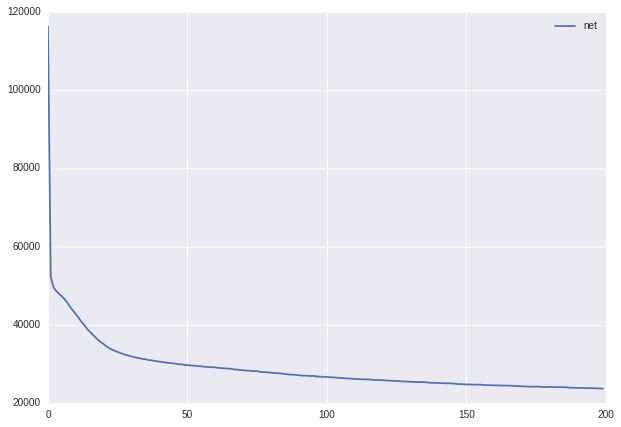

In [20]:
#plt.plot(logistic_result[1])
plt.plot(net_shared_result[1], label='net')

plt.legend()

In [21]:
model = net_shared

kaggle_puz = []
kaggle_sln = []
for i, line in enumerate(open('/home/spencebeecher/sudoku_kaggle_test.csv', 'r').read().splitlines()[1:]):
    quiz, solution = line.split(",")
    kaggle_puz.append([int(c) for c in quiz])
    kaggle_sln.append([int(c) for c in solution])
    

kaggle_puz = np.array(kaggle_puz).reshape((-1, 9, 9))
kaggle_sln = np.array(kaggle_sln).reshape((-1, 9, 9))

scores = []
for puz, sln in zip(kaggle_puz, kaggle_sln):
    p = predict_puzzle(puz, model)
    score = accuracy(sln, puz, p)
    scores.append(score)
print(m_name)
print(scores)
print(np.mean(scores))
print('')

NetShared 0.2 729 7290 729 5 10 100
[0.95744680851063835, 1.0, 0.82978723404255317, 0.9555555555555556, 0.68085106382978722, 1.0, 0.33962264150943394, 0.38181818181818183, 0.40000000000000002, 0.56603773584905659, 0.38461538461538464, 0.2857142857142857, 0.42857142857142855, 0.40000000000000002, 0.40000000000000002, 0.73684210526315785, 0.32727272727272727, 0.4107142857142857, 0.375, 0.36363636363636365, 0.44444444444444442, 0.34545454545454546, 0.34545454545454546, 0.33333333333333331, 0.56000000000000005, 0.56000000000000005, 0.8571428571428571, 0.71698113207547165, 0.66666666666666663, 0.50980392156862742]
0.552092241601



In [34]:
with open(file_name, 'r') as f:
    with open('attempt.csv', 'w') as attempt:
        for _ in range(num_examples):
            x, y = get_x_y(f, batches=1)
            x, y = x[0], y[0]
            puzz = one_hot_to_matrix(x)
            answer = one_hot_to_matrix(y)
            p = predict_puzzle(puzz, model)

            
            if (p == puzz).sum() == 81:
                continue
            
            p = np.multiply(puzz, p == puzz)
            
            
            
            for c in p.flatten():
                attempt.write(str(c))
            attempt.write(',')
            for c in answer.flatten():
                attempt.write(str(c))
            attempt.write('\n')
            

KeyboardInterrupt: 

In [81]:
!head attempt.csv

004300209005009001070060043006002087190007400050083000600000105003508690042910300,864371259325849761971265843436192587198657432257483916689734125713528694542916378


In [77]:
one_hot_to_matrix(x)

TypeError: 'list' object is not callable

In [274]:
#pool = torch.multiprocessing.Pool(num_threads)

In [69]:
print(NetShared(729, 1458*5, 729, dropout_prob, 1))

NetShared 0.5 729 7290 729 1


In [59]:
num_examples = 1000000

dropout_prob = 0.5


for epochs in [1]: 
    for batch_size in [100]: 

        m = []
        #m.append(LogisticRegression())
        m.append(NetShared(729, 1458*5, 729, dropout_prob, 1))
        
        #m.append(NetShared(729, 1458*5, 729, dropout_prob, 3))
        
        #m.append(ConvNetShared(3, 600, 0.1))
        #m.append(ConvNet(2, 600, 0.1, True))
        #m.append(ConvNet(2, 600, 0.1, False))

        for model in m:

            m_name = str(model) + ' {} {}'.format(epochs, batch_size)

            models[m_name] = model
            model.share_memory()

            if False:
                result = pool.apply_async(
                            run_training, 
                            (file_name, m_name, model, num_examples, epochs, batch_size))
            else:
                result = run_training(file_name, m_name, model, num_examples, epochs, batch_size)
            results.append(result)
                

In [60]:
for r in results:
    #if r.ready():
        m_name, lr, tr, model = r#.get()

        loss_results[m_name] = lr
        time_results[m_name] = tr
len(tr), len(lr)

(20, 20)

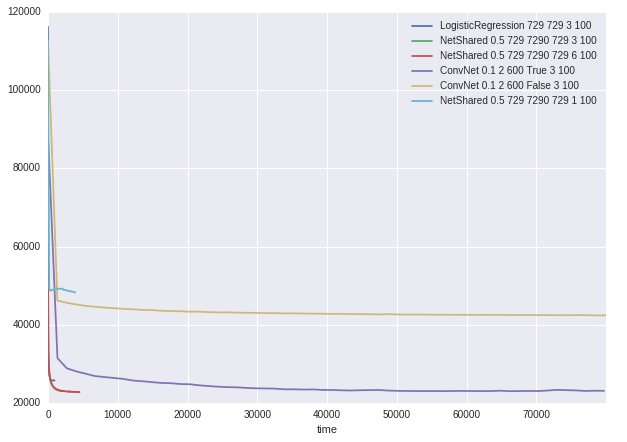

In [61]:
   
ax = None
for name, series in list(loss_results.items()):
    ax = pd.DataFrame({'loss': series, 'time': time_results[name]}).plot(
        y='loss', x='time', label=name, ax=ax)
plt.legend()    

#plt.ylim(0.05, 0.25)        

In [49]:
models.keys()

dict_keys(['LogisticRegression 729 729 3 100', 'NetShared 0.5 729 7290 729 3 100', 'NetShared 0.5 729 7290 729 6 100', 'ConvNet 0.1 3 600 True 6 100', 'ConvNet 0.1 2 600 True 3 100', 'ConvNet 0.1 2 600 False 3 100'])

In [62]:

for m_name in [x[0] for x in results]:
    #m_name = 'LogisticRegression 729 729 1 400'
    scores = []
    for puz, sln in zip(kaggle_puz, kaggle_sln):
        p = predict_puzzle(puz, models[m_name])
        score = accuracy(sln, puz, p)
        scores.append(score)
    print(m_name)
    print(scores)
    print(np.mean(scores))
    print('')

LogisticRegression 729 729 3 100
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.54716981132075471, 1.0, 0.70909090909090911, 0.37735849056603776, 0.5, 0.625, 0.9107142857142857, 0.67272727272727273, 0.43636363636363634, 0.43859649122807015, 0.32727272727272727, 0.7321428571428571, 0.39285714285714285, 0.67272727272727273, 1.0, 0.59999999999999998, 0.41818181818181815, 0.83333333333333337, 0.56000000000000005, 1.0, 1.0, 0.62264150943396224, 1.0, 0.80392156862745101]
0.739336637553

NetShared 0.5 729 7290 729 3 100
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.47169811320754718, 1.0, 0.41818181818181815, 0.39622641509433965, 0.59615384615384615, 0.375, 0.6428571428571429, 0.80000000000000004, 0.61818181818181817, 0.33333333333333331, 0.23636363636363636, 0.8214285714285714, 0.32142857142857145, 0.96363636363636362, 0.55555555555555558, 0.65454545454545454, 0.34545454545454546, 0.53703703703703709, 0.71999999999999997, 1.0, 1.0, 0.64150943396226412, 1.0, 0.72549019607843135]
0.705802728417

NetShared 0.5 729 7290 7

In [52]:
kaggle_puz_train = []
kaggle_sln_train = []
for i, line in enumerate(open('kaggle_sudoku.csv', 'r').read().splitlines()[1:400]):
    quiz, solution = line.split(",")
    kaggle_puz_train.append([int(c) for c in quiz])
    kaggle_sln_train.append([int(c) for c in solution])
    

kaggle_puz_train = np.array(kaggle_puz).reshape((-1, 9, 9))
kaggle_sln_train = np.array(kaggle_sln).reshape((-1, 9, 9))    

for m_name in models.keys():
    #m_name = 'LogisticRegression 729 729 1 400'
    scores = []
    for puz, sln in zip(kaggle_puz_train, kaggle_sln_train):
        p = predict_puzzle(puz, models[m_name])
        score = accuracy(sln, puz, p)
        scores.append(score)
    print(m_name)
    print(np.mean(scores))
    print('')

LogisticRegression 729 729 3 100
0.739336637553

NetShared 0.5 729 7290 729 3 100
0.705802728417

NetShared 0.5 729 7290 729 6 100
0.7458203688

ConvNet 0.1 3 600 True 6 100
0.656262983974

ConvNet 0.1 2 600 True 3 100
0.652182653059

ConvNet 0.1 2 600 False 3 100
0.272255247858



In [ ]:

for m_name in [x[0] for x in results]:
    #m_name = 'LogisticRegression 729 729 1 400'
    scores = []
    for puz, sln in zip(kaggle_puz, kaggle_sln):
        p = predict_puzzle(puz, models[m_name])
        score = accuracy(sln, puz, p)
        scores.append(score)
    print(m_name)
    print(scores)
    print(np.mean(scores))
    print('')

In [34]:
num_examples = 2000

dropout_prob = 0.5

for model_class in [LogisticRegression]:
        for h_size in [5 * hidden_size]:
            for epochs in [1]: 
                for batch_size in [400]:                
                    model = model_class(input_size, h_size, output_size, dropout_prob)
                    m_name = str(model) + ' {} {}'.format(epochs, batch_size)

                    models[m_name] = model
                    model.share_memory()
                    result = pool.apply_async(
                        run_training, 
                        (file_name, m_name, model, num_examples, epochs, batch_size))

                    results.append(result)

                    #result = run_training(file_name, m_name, model, num_examples, epochs)

In [36]:
list(models.keys())

['LogisticRegression 729 729 20 100',
 'LogisticRegression 729 729 20 200',
 'WideAnd2DeepNetShared 0.5 729 7290 729 20 100',
 'WideAnd2DeepNetShared 0.5 729 7290 729 20 200',
 'WideAndDeepNetShared 0.5 729 7290 729 20 100',
 'WideAndDeepNetShared 0.5 729 7290 729 20 200',
 'LogisticRegression 729 729 20 300',
 'LogisticRegression 729 729 20 400',
 'WideAndDeepNetShared 0.5 729 7290 729 20 300',
 'WideAndDeepNetShared 0.5 729 7290 729 20 400']

In [127]:
for r in results:
    print(r.get()[0] if r.ready() else False)

LogisticRegression 729 729 20 100
LogisticRegression 729 729 20 200
False
False
WideAndDeepNetShared 0.5 729 7290 729 20 100
WideAndDeepNetShared 0.5 729 7290 729 20 200
LogisticRegression 729 729 20 300
LogisticRegression 729 729 20 400
WideAndDeepNetShared 0.5 729 7290 729 20 300
WideAndDeepNetShared 0.5 729 7290 729 20 400


(0.05, 0.25)

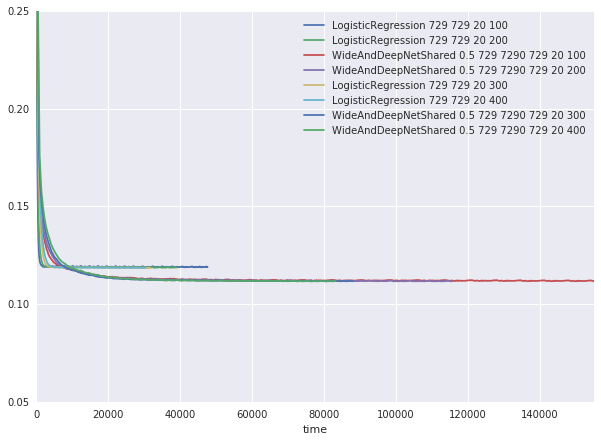

In [38]:
for r in results:
    if r.ready():
        m_name, lr, tr, model = r.get()

        loss_results[m_name] = lr
        time_results[m_name] = tr
        
ax = None
for name, series in loss_results.items():
    ax = pd.DataFrame({'loss': series, 'time': time_results[name]}).plot(
        y='loss', x='time', label=name, ax=ax)
plt.legend()    

plt.ylim(0.05, 0.25)        

(0.05, 0.25)

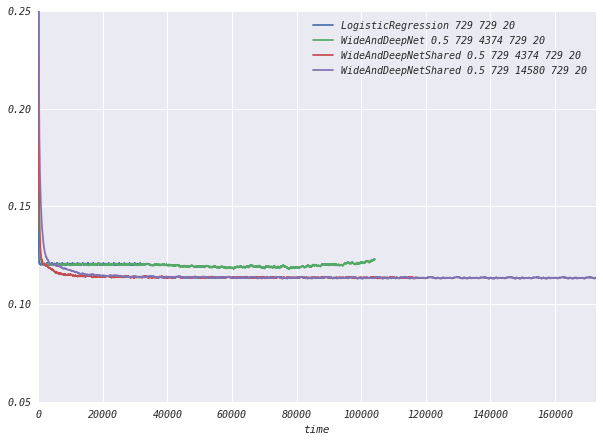

In [53]:
for r in results:
    if r.ready():
        m_name, lr, tr, model = r.get()

        loss_results[m_name] = lr
        time_results[m_name] = tr
        
ax = None
for name, series in loss_results.items():
    ax = pd.DataFrame({'loss': series, 'time': time_results[name]}).plot(
        y='loss', x='time', label=name, ax=ax)
plt.legend()    

plt.ylim(0.05, 0.25)        

In [149]:
np.array([0,0,1,0,0]).T * np.matrix(np.ones((9,9))) 

matrix([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.]])

In [150]:
y[1].shape

(729,)

In [468]:
def predict(puz, model, is_only_blanks=True):
    model.eval()
    predictions = model(Variable(torch.Tensor([puz])))
    predictions = predictions[0]
    
    predictions = F.softmax(predictions.reshape((9, 81)), dim=0)
    predictions = predictions.reshape(9*81)
    
    predictions = np.array(predictions.tolist())
    min_pred = predictions.min() - 1
    
    if is_only_blanks:
        for i, e in enumerate(puz != 0):
            if e:
                predictions[i] = min_pred
                curr = i
                curr += 81
                while curr % 729 != i:
                    predictions[curr % 729] = min_pred
                    curr += 81  
        
    return predictions
    
def predict_best(puz, model):    
    predictions = predict(puz, model)
    
    ret = np.zeros(81*9, dtype=int)
        
    ret[np.argmax(predictions)] = 1  
    
    return ret


def predict_puzzle(puzzle, model):
    
    num_zeros = np.sum(puzzle == 0)
    r = matrix_to_one_hot(puzzle)
    for _ in range(num_zeros):
        pred = predict_best(r, model)
        
        r = pred + r
        
    r = one_hot_to_matrix(r)
    return r


def accuracy(answer, puzzle, prediction):
    num_zeros = np.sum(puzzle == 0)
    return ((prediction == answer).sum() - (81 - num_zeros)) / num_zeros


In [176]:
kaggle_puz = []
kaggle_sln = []
for i, line in enumerate(open('/home/spencebeecher/sudoku_kaggle_test.csv', 'r').read().splitlines()[1:]):
    quiz, solution = line.split(",")
    kaggle_puz.append([int(c) for c in quiz])
    kaggle_sln.append([int(c) for c in solution])
    

kaggle_puz = np.array(kaggle_puz).reshape((-1, 9, 9))
kaggle_sln = np.array(kaggle_sln).reshape((-1, 9, 9))

In [298]:
m_name = 'WideAndDeepNetShared 0.5 729 7290 729 20 400'
scores = []
for puz, sln in zip(kaggle_puz, kaggle_sln):
    p = predict_puzzle(puz, models[m_name])
    score = accuracy(sln, puz, p)
    scores.append(score)
print(scores)
np.mean(scores)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.36363636363636365, 0.47169811320754718, 0.59615384615384615, 0.30357142857142855, 0.39285714285714285, 1.0, 0.45454545454545453, 0.64912280701754388, 0.45454545454545453, 0.375, 0.3392857142857143, 0.72727272727272729, 0.87037037037037035, 0.59999999999999998, 1.0, 0.35185185185185186, 0.80000000000000004, 1.0, 1.0, 0.75471698113207553, 1.0, 0.92156862745098034]


0.74753989609661686

In [297]:
#with open('sudoku_big.dat', 'r') as f:
# 953, 872
with open('sudoku_eval.dat', 'r') as f:
    x, y = get_x_y(f, batches=1000)


#x, y = puz_x, puz_y
for model_name in list(models.keys()):    
    tot = 0
    for i in range(len(x)):
        r = predict_one(x[i], models[model_name])
        #print(np.sum(one_hot_to_matrix(r)==one_hot_to_matrix(y[i])))
        tot = tot + (np.sum(one_hot_to_matrix(r) == one_hot_to_matrix(y[i])) == 1)
        
    print(model_name, ' ', tot * 1.0 / len(x))

ValueError: too many values to unpack (expected 2)

In [159]:
score_puzzle(hard, sudoku.solve_puzzle(hard)[-1], models[m_name])

(0.15217391304347827, array([[9, 4, 7, 8, 1, 2, 5, 3, 6],
        [2, 3, 8, 7, 5, 6, 9, 4, 1],
        [6, 5, 1, 3, 9, 4, 7, 2, 8],
        [4, 9, 5, 6, 8, 1, 2, 7, 3],
        [1, 7, 2, 5, 3, 4, 8, 6, 9],
        [6, 8, 3, 9, 7, 7, 4, 1, 5],
        [3, 2, 4, 1, 6, 5, 6, 9, 7],
        [7, 1, 6, 2, 2, 9, 3, 5, 4],
        [5, 6, 9, 7, 4, 3, 1, 8, 2]]))

In [158]:
predict(matrix_to_one_hot(hard), models[m_name] ).astype(int)

array([-53, -13, -53, -53,   0, -13, -53, -53, -53,  -1, -53,  -1, -12,
       -53, -14, -14, -53,   0,   0, -53,  -1, -53,  -1, -14, -15,   0,
         0, -13, -53, -53, -53, -13, -53, -27, -14, -53,   0, -53,   0,
       -53, -13, -13, -14, -53,  -1, -53, -13,   0, -53, -13, -53, -13,
         0, -53, -26, -27, -26, -53, -13, -53, -29, -25, -26, -53, -53,
       -13, -24, -53, -38, -28, -53, -24, -53, -25, -53, -53, -24, -53,
       -53, -11, -53, -53,   0, -53, -53, -15,   0, -53, -53, -53,  -1,
       -53,  -1,   0, -53,   0,   0, -53, -14,  -2, -53,  -1, -53, -17,
        -1,  -1,  -1, -14,  -1, -53, -53, -53, -13, -53,   0,   0, -53,
        -1, -53,  -2, -53, -15,   0,   0, -53, -14, -53,   0,  -1, -53,
       -14, -53,   0,   0, -53,   0,   0,   0, -53, -14, -53, -15, -13,
       -14, -53, -53, -14, -12, -53, -14, -27, -53, -27, -53, -12, -53,
       -53, -27, -53, -53, -13, -53, -53, -25, -53, -53, -24, -37, -53,
       -53, -53, -12, -53, -13, -24, -53, -38, -25, -53, -38, -2

In [135]:
predict(matrix_to_one_hot(np.array([[9, 4, 7, 8, 1, 2, 5, 3, 6],
        [2, 3, 8, 0, 7, 6, 9, 4, 1],
        [0, 5, 6, 4, 9, 0, 7, 2, 8],
        [4, 9, 5, 6, 8, 1, 2, 7, 3],
        [1, 7, 2, 5, 3, 4, 8, 6, 9],
        [6, 8, 3, 9, 0, 7, 4, 1, 5],
        [8, 2, 4, 1, 6, 5, 0, 9, 7],
        [7, 1, 0, 0, 2, 9, 6, 5, 4],
        [5, 6, 9, 7, 4, 3, 1, 8, 2]])), models[m_name], False ).astype(int)

array([-38, -39, -24, -37,  17, -37, -49, -50, -38, -39, -38, -24, -36,
       -41, -51, -37, -38,  17, -10, -24,  -8, -40, -25, -23, -38, -37,
       -24, -37, -50, -37, -36, -36,  18, -49, -37, -49,  17, -37, -24,
       -49, -49, -36, -49, -37, -49, -37, -50, -37, -52, -35, -37, -37,
        18, -36, -51, -38, -37,  18, -37, -37, -24, -49, -49, -39,  17,
       -10, -23, -49, -52, -38, -48, -49, -50, -37, -36, -37, -48, -49,
        17, -36, -36, -36, -49, -48, -24, -38,  17, -49, -36, -49,  18,
       -37, -36, -23, -53, -37, -49, -36, -49, -23, -48, -51, -40, -50,
       -24, -37,  18, -36, -50, -49, -37, -24, -39, -40,  17, -37, -37,
       -37, -38,  16, -24, -38, -39, -37, -49, -49, -36, -36, -24,  -8,
       -10, -23, -25, -36, -38, -38,  18, -36, -37, -37, -50, -36, -49,
       -36, -49, -36, -36, -11,  17, -40, -49, -49, -37, -49, -36, -49,
       -37, -37, -49, -36, -36,  18, -38, -38, -51, -24, -38, -38, -26,
        16, -38, -24,  15, -38, -11, -42, -38, -37, -38, -51, -1

In [120]:
sudoku.is_correct(sudoku.solve_puzzle(hard)[-1])

True

In [99]:
hard = np.array([
       [9, 0, 7, 8, 0, 0, 5, 3, 6],
       [0, 3, 0, 0, 5, 0, 0, 4, 0],
       [0, 5, 0, 3, 0, 0, 0, 0, 0],
       [0, 9, 5, 6, 0, 1, 0, 0, 3],
       [0, 7, 0, 5, 0, 0, 0, 6, 0],
       [6, 0, 0, 9, 0, 7, 0, 0, 5],
       [0, 0, 0, 1, 0, 5, 0, 0, 0],
       [7, 1, 0, 0, 2, 0, 0, 5, 0],
       [5, 0, 9, 7, 0, 3, 1, 0, 2]])

-inf

In [95]:


puzz = predict_one(matrix_to_one_hot(hard), models[m_name], n=0)
puzz = one_hot_to_matrix(puzz)
display(puzz)
print()

solved = sudoku.solve_puzzle(hard)[-1]
display(solved)

if np.any(solved==puzz):
    hard = hard+puzz
    print('correct!')

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[9, 2, 7, 8, 1, 4, 5, 3, 6],
       [1, 3, 6, 2, 5, 9, 8, 4, 7],
       [8, 5, 4, 3, 7, 6, 2, 9, 1],
       [4, 9, 5, 6, 8, 1, 7, 2, 3],
       [3, 7, 1, 5, 4, 2, 9, 6, 8],
       [6, 8, 2, 9, 3, 7, 4, 1, 5],
       [2, 6, 8, 1, 9, 5, 3, 7, 4],
       [7, 1, 3, 4, 2, 8, 6, 5, 9],
       [5, 4, 9, 7, 6, 3, 1, 8, 2]])

In [96]:
hard

array([[9, 0, 7, 8, 0, 0, 5, 3, 6],
       [0, 3, 0, 0, 5, 0, 0, 4, 0],
       [0, 5, 0, 3, 0, 0, 0, 0, 0],
       [0, 9, 5, 6, 0, 1, 0, 0, 3],
       [0, 7, 0, 5, 0, 0, 0, 6, 0],
       [6, 0, 0, 9, 0, 7, 0, 0, 5],
       [0, 0, 0, 1, 0, 5, 0, 0, 0],
       [7, 1, 0, 0, 2, 0, 0, 5, 0],
       [5, 0, 9, 7, 0, 3, 1, 0, 2]])

In [ ]:
WideAndDeepNet 0.5 729 1458 729 5 False   0.079
WideAndDeepNetShared 0.5 729 1458 729 5 False   0.078
NetShared 0.5 729 1458 729 5 False   0.066
WideAndDeepNet 0.5 729 1458 729 5 True   0.88
WideAndDeepNetShared 0.5 729 1458 729 5 True   0.941
NetShared 0.5 729 1458 729 5 True   0.942
WideAndDeepNet 0.5 729 2916 729 5 True   0.864
WideAndDeepNet 0.5 729 7290 729 5 True   0.869
WideAndDeepNetShared 0.5 729 2916 729 5 True   0.958
WideAndDeepNetShared 0.5 729 7290 729 5 True   0.968
NetShared 0.5 729 2916 729 5 True   0.946
NetShared 0.5 729 7290 729 5 True   0.968
WideAndDeepNetShared 0.5 729 1458 729 1 False   0.067

In [40]:
hidden_size*5

7290

In [46]:
#with open('sudoku_big.dat', 'r') as f:
# 953, 872
with open('sudoku_eval.dat', 'r') as f:
    x, y = get_x_y(f, batches=1000)


#x, y = puz_x, puz_y
for model_name in list(models.keys()):    
    tot = 0
    n = 0
    for i in range(len(x)):
        r = ml_solve_puzzle_answer(x[i], models[model_name], y[i])
        #print(np.sum(one_hot_to_matrix(r)==one_hot_to_matrix(y[i])))
        tot = tot + (one_hot_to_matrix(r) == one_hot_to_matrix(y[i])).sum() / 81.0
        n = n + 1
        
    print(model_name, ' ', tot * 1.0 / n)

NameError: name 'ml_solve_puzzle_answer' is not defined

In [47]:
def ml_solve_puzzle_answer(puz, model, answer=None):
    #answer = one_hot_to_matrix(answer)
    num_zeros = np.sum(one_hot_to_matrix(puz) == 0)
    curr_puz = puz.copy()
    
    i = 0 
    while num_zeros > 0 and i < 90:
        #print(i)
        pred = predict_one(curr_puz, model, 0)
        
        if not answer is None and not (answer & pred).sum() == 1:
            return curr_puz
        
        curr_puz += pred
        
        parr = one_hot_to_matrix(curr_puz)
        
        num_zeros = np.sum(parr == 0)
        i += 1
        
    return curr_puz

In [224]:
i = 8
model = models['WideAndDeepNetShared 0.5 729 4374 729 20 True']

r = ml_solve_puzzle_answer(
        x[i], 
        model,
        y[i]
    )



#print((one_hot_to_matrix(y[i]) == one_hot_to_matrix(r)) | (one_hot_to_matrix(r) == 0))
#print(one_hot_to_matrix(x[i]))
#print()

print(one_hot_to_matrix(y[i]))
print()


print(one_hot_to_matrix(r))
print()    

print(one_hot_to_matrix(predict_one(r, model, 0)))

[[8 2 3 9 5 7 1 4 6]
 [7 6 5 8 1 4 2 3 9]
 [4 9 1 6 3 2 8 5 7]
 [1 4 6 2 7 9 3 8 5]
 [5 7 8 3 4 6 9 2 1]
 [9 3 2 5 8 1 7 6 4]
 [2 1 9 4 6 8 5 7 3]
 [3 8 4 7 9 5 6 1 2]
 [6 5 7 1 2 3 4 9 8]]

[[0 0 0 0 0 0 0 0 0]
 [0 6 5 8 1 4 0 0 0]
 [0 0 1 0 0 2 0 0 7]
 [0 0 0 0 0 0 0 0 0]
 [5 7 8 3 0 6 0 0 1]
 [0 3 0 5 8 1 7 0 4]
 [0 1 9 0 0 8 0 7 3]
 [0 8 4 7 0 5 0 1 2]
 [0 5 7 1 2 0 0 9 8]]

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 7 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


In [164]:
rr

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [157]:
print(one_hot_to_matrix(x[i]))
print()
print(one_hot_to_matrix(y[i]))
print()



print(one_hot_to_matrix(predict_one(x[i], model, 2)))
print()
print(one_hot_to_matrix(predict_one(x[i], model, 1)))
print()
print(one_hot_to_matrix(predict_one(x[i], model, 0)))

[[0 0 7 0 2 0 0 9 8]
 [0 0 4 7 0 5 0 1 2]
 [0 1 9 0 0 0 0 7 3]
 [0 3 0 5 8 1 0 0 4]
 [5 7 8 3 0 6 0 0 1]
 [0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 2 0 0 7]
 [0 6 5 8 1 4 0 0 0]
 [0 0 0 0 0 0 0 0 0]]

[[6 5 7 1 2 3 4 9 8]
 [3 8 4 7 9 5 6 1 2]
 [2 1 9 4 6 8 5 7 3]
 [9 3 2 5 8 1 7 6 4]
 [5 7 8 3 4 6 9 2 1]
 [1 4 6 2 7 9 3 8 5]
 [4 9 1 6 3 2 8 5 7]
 [7 6 5 8 1 4 2 3 9]
 [8 2 3 9 5 7 1 4 6]]

[[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 8 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]

[[0 5 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]

[[0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


In [147]:
for rr in predict_one(x[i], model, 3):
    print(one_hot_to_matrix(rr))
    print('')   

[[0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]

[[0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]

[[0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]



In [118]:
i = 4

puz = one_hot_to_matrix(x[i])

res = one_hot_to_matrix(
    ml_solve_puzzle_answer(
        matrix_to_one_hot(puz), 
        models['WideAndDeepNetShared 0.5 729 4374 729 20 True'],
        y[i]
    )
        
        
)

display(one_hot_to_matrix(x[i]))
print()
display(one_hot_to_matrix(y[i]))
print()
display(res)

display(number_match(matrix_to_one_hot(puz), matrix_to_one_hot(res)))


ValueError: operands could not be broadcast together with shapes (9,9) (729,) 

In [101]:
one_hot_to_matrix(y[i]) == res

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True]], dtype=bool)

In [103]:
number_match(matrix_to_one_hot(res), y[i])

81

In [102]:
number_match(y[i], matrix_to_one_hot(res))

81

In [ ]:
def number_match(guess, answer):
    return (one_hot_to_matrix(guess) == one_hot_to_matrix(answer)).sum() 

In [ ]:
#def predict(puz, model):
#    model.eval()
#    predictions = model(Variable(torch.Tensor([puz])))
#    predictions = np.array(predictions[0].tolist())
#    return argmax_to_matrix(predictions)



In [163]:
for i in range(len(y)):
    if not np.all(matrix_to_one_hot(one_hot_to_matrix(y[i])) == y[i]):
        print("bad")
        break
        
    if not np.all(one_hot_to_matrix(matrix_to_one_hot(one_hot_to_matrix(y[i]))) == one_hot_to_matrix(y[i])):
        print("bad")
        break        

In [164]:
sudoku.is_complete(one_hot_to_matrix(y[0])) and sudoku.is_correct(one_hot_to_matrix(y[0]))

True

In [153]:
sudoku.solve_puzzle(one_hot_to_matrix(x[0]))

[array([[6, 4, 1, 7, 5, 9, 3, 2, 8],
        [9, 3, 2, 4, 1, 8, 5, 6, 7],
        [7, 5, 8, 2, 3, 6, 1, 9, 4],
        [5, 8, 3, 9, 7, 2, 6, 4, 1],
        [1, 2, 9, 6, 4, 3, 8, 7, 5],
        [4, 6, 7, 1, 8, 5, 2, 3, 9],
        [3, 7, 5, 8, 6, 4, 9, 1, 2],
        [2, 1, 6, 5, 9, 7, 4, 8, 3],
        [8, 9, 4, 3, 2, 1, 7, 5, 6]])]

In [85]:
with open('sudoku_eval.dat', 'r') as f:
    x, y = get_x_y(f, batches=1000)


#x, y = puz_x, puz_y
for model_name in models.keys():    
    tot = 0
    for i in range(len(x)):
        r = predict_one(x[i], models[model_name])
        #print(np.sum(one_hot_to_matrix(r)==one_hot_to_matrix(y[i])))
        tot = tot + (np.sum(one_hot_to_matrix(r) == one_hot_to_matrix(y[i])) == 1)
        
    print(model_name, ' ', tot * 1.0 / len(x))
    

wideanddeepnet 2917   0.877


In [69]:
with open('sudoku_eval.dat', 'r') as f:
    x, y = get_x_y(f, batches=1000)


#x, y = puz_x, puz_y
for model_name in models.keys():    
    tot = 0
    for i in range(len(x)):
        r = predict_one(x[i], models[model_name])
        #print(np.sum(one_hot_to_matrix(r)==one_hot_to_matrix(y[i])))
        tot = tot + (np.sum(one_hot_to_matrix(r) == one_hot_to_matrix(y[i])) == 1)
        
    print(model_name, ' ', tot * 1.0 / len(x))
    

wideanddeepnet 1458   0.837


In [97]:
with open('sudoku_eval.dat', 'r') as f:
    x, y = get_x_y(f, batches=1000)


#x, y = puz_x, puz_y
for model_name in models.keys():    
    tot = 0
    for i in range(len(x)):
        r = predict(x[i], models[model_name])
        #print(np.sum(one_hot_to_matrix(r)==one_hot_to_matrix(y[i])))
        tot = tot + (np.sum(r == one_hot_to_matrix(y[i])))
        display(r)
        break
    print(model_name, ' ', tot * 1.0 / len(x))
    

array([[6, 2, 1, 7, 5, 6, 2, 4, 7],
       [9, 2, 2, 7, 7, 9, 3, 2, 7],
       [6, 8, 8, 3, 5, 6, 3, 4, 8],
       [5, 3, 8, 7, 7, 2, 6, 4, 1],
       [9, 2, 9, 9, 4, 4, 2, 4, 4],
       [6, 2, 7, 7, 7, 2, 6, 9, 6],
       [5, 4, 4, 8, 4, 4, 2, 5, 8],
       [6, 6, 6, 8, 9, 9, 3, 8, 8],
       [5, 4, 4, 3, 4, 1, 3, 5, 3]])

wideanddeepnet 1458   0.028


array([[6, 2, 1, 7, 5, 6, 2, 4, 7],
       [9, 2, 2, 7, 7, 9, 3, 2, 7],
       [6, 8, 8, 3, 5, 6, 3, 4, 8],
       [5, 3, 8, 7, 7, 2, 6, 4, 1],
       [9, 2, 9, 9, 4, 4, 2, 4, 4],
       [6, 2, 7, 7, 7, 2, 6, 9, 6],
       [5, 4, 4, 8, 4, 4, 2, 5, 8],
       [6, 6, 6, 8, 9, 9, 3, 8, 8],
       [5, 4, 4, 3, 3, 1, 3, 5, 3]])

wideanddeepnet 729.0   0.028


array([[9, 8, 1, 9, 4, 6, 8, 5, 5],
       [8, 9, 5, 7, 3, 7, 6, 4, 5],
       [1, 7, 9, 3, 5, 7, 6, 2, 1],
       [3, 8, 3, 5, 9, 2, 9, 4, 6],
       [9, 4, 4, 4, 2, 5, 1, 9, 4],
       [9, 2, 8, 2, 3, 1, 2, 4, 6],
       [6, 1, 5, 4, 4, 3, 9, 4, 5],
       [4, 5, 3, 5, 4, 7, 5, 5, 5],
       [9, 3, 4, 8, 7, 5, 2, 9, 4]])

wideanddeepnet 2916   0.011


array([[6, 2, 1, 7, 5, 6, 2, 4, 7],
       [9, 2, 2, 7, 7, 9, 3, 2, 7],
       [6, 8, 8, 3, 5, 6, 3, 4, 8],
       [5, 3, 8, 7, 7, 2, 6, 4, 1],
       [9, 2, 9, 9, 4, 4, 2, 4, 4],
       [6, 2, 7, 7, 7, 2, 6, 9, 6],
       [5, 4, 4, 8, 4, 4, 2, 5, 8],
       [6, 6, 6, 8, 9, 9, 3, 8, 8],
       [5, 4, 4, 3, 3, 1, 3, 5, 3]])

wideanddeepnet 14580   0.028


array([[6, 2, 1, 7, 5, 6, 2, 4, 7],
       [9, 2, 2, 7, 7, 9, 3, 2, 7],
       [6, 8, 8, 3, 5, 6, 3, 4, 8],
       [5, 3, 8, 7, 7, 2, 6, 4, 1],
       [9, 2, 9, 9, 4, 4, 2, 4, 4],
       [6, 2, 7, 7, 7, 2, 6, 9, 6],
       [5, 4, 4, 8, 4, 4, 2, 5, 8],
       [6, 6, 6, 8, 9, 9, 3, 8, 8],
       [5, 4, 4, 3, 3, 1, 3, 5, 3]])

wideanddeepnet 2917   0.028


In [98]:
threshold = 0

with open('sudoku_eval.dat', 'r') as f:
    x, y = get_x_y(f, batches=1000)



#x, y = puz_x, puz_y
for model_name in models.keys():    
    tot = 0
    print(model_name)
    for i in range(len(x)):
        r = predict_one(x[i], models[model_name])
        #print(np.sum(one_hot_to_matrix(r)==one_hot_to_matrix(y[i])))
        is_correct = (np.sum(one_hot_to_matrix(r) == one_hot_to_matrix(y[i])) == 1)
        if is_correct and np.random.rand() > threshold:
            print(i)
            display(one_hot_to_matrix(r))
            print('')    
            display(one_hot_to_matrix(x[i]))
            print('')    
            display(one_hot_to_matrix(y[i]))            
            break
    print('')    
    print('')        
    print('')        
    print('')       
    for i in range(len(x)):
        r = predict_one(x[i], models[model_name])
        #print(np.sum(one_hot_to_matrix(r)==one_hot_to_matrix(y[i])))
        is_correct = (np.sum(one_hot_to_matrix(r) == one_hot_to_matrix(y[i])) == 1)
        if not is_correct and np.random.rand() > threshold:
            print(i)
            display(one_hot_to_matrix(r))
            print('')    
            display(one_hot_to_matrix(x[i]))
            print('')    
            display(one_hot_to_matrix(y[i]))           
            break    
            
    print('')        
    print('')        
    print('')                
#    print(model_name, ' ', tot * 1.0 / len(x))
    

wideanddeepnet 1458
13


array([[0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 4, 0, 0, 1, 0, 8, 5],
       [6, 0, 9, 3, 0, 8, 0, 4, 0],
       [0, 8, 0, 4, 0, 0, 0, 3, 2],
       [2, 0, 8, 0, 4, 0, 0, 0, 7],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 6, 0, 2, 5, 0, 0, 0, 9],
       [0, 0, 2, 5, 9, 0, 0, 0, 3],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 9, 7, 0, 0, 2, 0, 0, 4]])

array([[3, 2, 4, 9, 7, 1, 6, 8, 5],
       [6, 5, 9, 3, 2, 8, 7, 4, 1],
       [7, 8, 1, 4, 6, 5, 9, 3, 2],
       [2, 1, 8, 6, 4, 9, 3, 5, 7],
       [9, 7, 5, 1, 8, 3, 4, 2, 6],
       [4, 6, 3, 2, 5, 7, 8, 1, 9],
       [8, 4, 2, 5, 9, 6, 1, 7, 3],
       [5, 3, 6, 7, 1, 4, 2, 9, 8],
       [1, 9, 7, 8, 3, 2, 5, 6, 4]])





0


array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 6, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 1, 8, 5, 6, 0],
       [7, 0, 0, 2, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 6, 0, 3, 8, 7, 5],
       [4, 0, 0, 1, 8, 5, 0, 3, 0],
       [3, 7, 0, 0, 0, 0, 9, 1, 0],
       [2, 1, 0, 5, 0, 7, 4, 0, 0],
       [8, 9, 0, 0, 2, 0, 7, 0, 0]])

array([[6, 4, 1, 7, 5, 9, 3, 2, 8],
       [9, 3, 2, 4, 1, 8, 5, 6, 7],
       [7, 5, 8, 2, 3, 6, 1, 9, 4],
       [5, 8, 3, 9, 7, 2, 6, 4, 1],
       [1, 2, 9, 6, 4, 3, 8, 7, 5],
       [4, 6, 7, 1, 8, 5, 2, 3, 9],
       [3, 7, 5, 8, 6, 4, 9, 1, 2],
       [2, 1, 6, 5, 9, 7, 4, 8, 3],
       [8, 9, 4, 3, 2, 1, 7, 5, 6]])




wideanddeepnet 729.0
13


array([[0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 4, 0, 0, 1, 0, 8, 5],
       [6, 0, 9, 3, 0, 8, 0, 4, 0],
       [0, 8, 0, 4, 0, 0, 0, 3, 2],
       [2, 0, 8, 0, 4, 0, 0, 0, 7],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 6, 0, 2, 5, 0, 0, 0, 9],
       [0, 0, 2, 5, 9, 0, 0, 0, 3],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 9, 7, 0, 0, 2, 0, 0, 4]])

array([[3, 2, 4, 9, 7, 1, 6, 8, 5],
       [6, 5, 9, 3, 2, 8, 7, 4, 1],
       [7, 8, 1, 4, 6, 5, 9, 3, 2],
       [2, 1, 8, 6, 4, 9, 3, 5, 7],
       [9, 7, 5, 1, 8, 3, 4, 2, 6],
       [4, 6, 3, 2, 5, 7, 8, 1, 9],
       [8, 4, 2, 5, 9, 6, 1, 7, 3],
       [5, 3, 6, 7, 1, 4, 2, 9, 8],
       [1, 9, 7, 8, 3, 2, 5, 6, 4]])





0


array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 6, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 1, 8, 5, 6, 0],
       [7, 0, 0, 2, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 6, 0, 3, 8, 7, 5],
       [4, 0, 0, 1, 8, 5, 0, 3, 0],
       [3, 7, 0, 0, 0, 0, 9, 1, 0],
       [2, 1, 0, 5, 0, 7, 4, 0, 0],
       [8, 9, 0, 0, 2, 0, 7, 0, 0]])

array([[6, 4, 1, 7, 5, 9, 3, 2, 8],
       [9, 3, 2, 4, 1, 8, 5, 6, 7],
       [7, 5, 8, 2, 3, 6, 1, 9, 4],
       [5, 8, 3, 9, 7, 2, 6, 4, 1],
       [1, 2, 9, 6, 4, 3, 8, 7, 5],
       [4, 6, 7, 1, 8, 5, 2, 3, 9],
       [3, 7, 5, 8, 6, 4, 9, 1, 2],
       [2, 1, 6, 5, 9, 7, 4, 8, 3],
       [8, 9, 4, 3, 2, 1, 7, 5, 6]])




wideanddeepnet 2916
0


array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 8, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 1, 8, 5, 6, 0],
       [7, 0, 0, 2, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 6, 0, 3, 8, 7, 5],
       [4, 0, 0, 1, 8, 5, 0, 3, 0],
       [3, 7, 0, 0, 0, 0, 9, 1, 0],
       [2, 1, 0, 5, 0, 7, 4, 0, 0],
       [8, 9, 0, 0, 2, 0, 7, 0, 0]])

array([[6, 4, 1, 7, 5, 9, 3, 2, 8],
       [9, 3, 2, 4, 1, 8, 5, 6, 7],
       [7, 5, 8, 2, 3, 6, 1, 9, 4],
       [5, 8, 3, 9, 7, 2, 6, 4, 1],
       [1, 2, 9, 6, 4, 3, 8, 7, 5],
       [4, 6, 7, 1, 8, 5, 2, 3, 9],
       [3, 7, 5, 8, 6, 4, 9, 1, 2],
       [2, 1, 6, 5, 9, 7, 4, 8, 3],
       [8, 9, 4, 3, 2, 1, 7, 5, 6]])





1


array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 9, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 6, 5, 8, 1, 4, 0, 0, 0],
       [0, 0, 1, 0, 0, 2, 0, 0, 7],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [5, 7, 8, 3, 0, 6, 0, 0, 1],
       [0, 3, 0, 5, 8, 1, 0, 0, 4],
       [0, 1, 9, 0, 0, 0, 0, 7, 3],
       [0, 0, 4, 7, 0, 5, 0, 1, 2],
       [0, 0, 7, 0, 2, 0, 0, 9, 8]])

array([[8, 2, 3, 9, 5, 7, 1, 4, 6],
       [7, 6, 5, 8, 1, 4, 2, 3, 9],
       [4, 9, 1, 6, 3, 2, 8, 5, 7],
       [1, 4, 6, 2, 7, 9, 3, 8, 5],
       [5, 7, 8, 3, 4, 6, 9, 2, 1],
       [9, 3, 2, 5, 8, 1, 7, 6, 4],
       [2, 1, 9, 4, 6, 8, 5, 7, 3],
       [3, 8, 4, 7, 9, 5, 6, 1, 2],
       [6, 5, 7, 1, 2, 3, 4, 9, 8]])




wideanddeepnet 14580
13


array([[0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 4, 0, 0, 1, 0, 8, 5],
       [6, 0, 9, 3, 0, 8, 0, 4, 0],
       [0, 8, 0, 4, 0, 0, 0, 3, 2],
       [2, 0, 8, 0, 4, 0, 0, 0, 7],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 6, 0, 2, 5, 0, 0, 0, 9],
       [0, 0, 2, 5, 9, 0, 0, 0, 3],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 9, 7, 0, 0, 2, 0, 0, 4]])

array([[3, 2, 4, 9, 7, 1, 6, 8, 5],
       [6, 5, 9, 3, 2, 8, 7, 4, 1],
       [7, 8, 1, 4, 6, 5, 9, 3, 2],
       [2, 1, 8, 6, 4, 9, 3, 5, 7],
       [9, 7, 5, 1, 8, 3, 4, 2, 6],
       [4, 6, 3, 2, 5, 7, 8, 1, 9],
       [8, 4, 2, 5, 9, 6, 1, 7, 3],
       [5, 3, 6, 7, 1, 4, 2, 9, 8],
       [1, 9, 7, 8, 3, 2, 5, 6, 4]])





0


array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 6, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 1, 8, 5, 6, 0],
       [7, 0, 0, 2, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 6, 0, 3, 8, 7, 5],
       [4, 0, 0, 1, 8, 5, 0, 3, 0],
       [3, 7, 0, 0, 0, 0, 9, 1, 0],
       [2, 1, 0, 5, 0, 7, 4, 0, 0],
       [8, 9, 0, 0, 2, 0, 7, 0, 0]])

array([[6, 4, 1, 7, 5, 9, 3, 2, 8],
       [9, 3, 2, 4, 1, 8, 5, 6, 7],
       [7, 5, 8, 2, 3, 6, 1, 9, 4],
       [5, 8, 3, 9, 7, 2, 6, 4, 1],
       [1, 2, 9, 6, 4, 3, 8, 7, 5],
       [4, 6, 7, 1, 8, 5, 2, 3, 9],
       [3, 7, 5, 8, 6, 4, 9, 1, 2],
       [2, 1, 6, 5, 9, 7, 4, 8, 3],
       [8, 9, 4, 3, 2, 1, 7, 5, 6]])




wideanddeepnet 2917
13


array([[0, 2, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 4, 0, 0, 1, 0, 8, 5],
       [6, 0, 9, 3, 0, 8, 0, 4, 0],
       [0, 8, 0, 4, 0, 0, 0, 3, 2],
       [2, 0, 8, 0, 4, 0, 0, 0, 7],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 6, 0, 2, 5, 0, 0, 0, 9],
       [0, 0, 2, 5, 9, 0, 0, 0, 3],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 9, 7, 0, 0, 2, 0, 0, 4]])

array([[3, 2, 4, 9, 7, 1, 6, 8, 5],
       [6, 5, 9, 3, 2, 8, 7, 4, 1],
       [7, 8, 1, 4, 6, 5, 9, 3, 2],
       [2, 1, 8, 6, 4, 9, 3, 5, 7],
       [9, 7, 5, 1, 8, 3, 4, 2, 6],
       [4, 6, 3, 2, 5, 7, 8, 1, 9],
       [8, 4, 2, 5, 9, 6, 1, 7, 3],
       [5, 3, 6, 7, 1, 4, 2, 9, 8],
       [1, 9, 7, 8, 3, 2, 5, 6, 4]])





0


array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 6, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0]])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 1, 8, 5, 6, 0],
       [7, 0, 0, 2, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 6, 0, 3, 8, 7, 5],
       [4, 0, 0, 1, 8, 5, 0, 3, 0],
       [3, 7, 0, 0, 0, 0, 9, 1, 0],
       [2, 1, 0, 5, 0, 7, 4, 0, 0],
       [8, 9, 0, 0, 2, 0, 7, 0, 0]])

array([[6, 4, 1, 7, 5, 9, 3, 2, 8],
       [9, 3, 2, 4, 1, 8, 5, 6, 7],
       [7, 5, 8, 2, 3, 6, 1, 9, 4],
       [5, 8, 3, 9, 7, 2, 6, 4, 1],
       [1, 2, 9, 6, 4, 3, 8, 7, 5],
       [4, 6, 7, 1, 8, 5, 2, 3, 9],
       [3, 7, 5, 8, 6, 4, 9, 1, 2],
       [2, 1, 6, 5, 9, 7, 4, 8, 3],
       [8, 9, 4, 3, 2, 1, 7, 5, 6]])

In [49]:
from importlib import reload
reload(sudoku)

i = 0

mtx = one_hot_to_matrix(x[i])
sln = one_hot_to_matrix(y[i])

print('matrix')
display(mtx)

print('\nsolution')
display(sln)


print('is solution correct ', sudoku.is_complete(sln) and sudoku.is_correct(sln))

print('algorithmic solutions')
display(sudoku.solve_step(mtx))

display(sudoku.get_possibilities(mtx)[1,2])

display(np.all(sudoku.solve_puzzle(mtx)[0] == sln))

array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 1, 8, 5, 6, 0],
       [7, 0, 0, 2, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 6, 0, 3, 8, 7, 5],
       [4, 0, 0, 1, 8, 5, 0, 3, 0],
       [3, 7, 0, 0, 0, 0, 9, 1, 0],
       [2, 1, 0, 5, 0, 7, 4, 0, 0],
       [8, 9, 0, 0, 2, 0, 7, 0, 0]])

array([[6, 4, 1, 7, 5, 9, 3, 2, 8],
       [9, 3, 2, 4, 1, 8, 5, 6, 7],
       [7, 5, 8, 2, 3, 6, 1, 9, 4],
       [5, 8, 3, 9, 7, 2, 6, 4, 1],
       [1, 2, 9, 6, 4, 3, 8, 7, 5],
       [4, 6, 7, 1, 8, 5, 2, 3, 9],
       [3, 7, 5, 8, 6, 4, 9, 1, 2],
       [2, 1, 6, 5, 9, 7, 4, 8, 3],
       [8, 9, 4, 3, 2, 1, 7, 5, 6]])

True
True


array([[0, 0, 1, 0, 0, 0, 3, 0, 0],
       [9, 0, 0, 0, 0, 0, 0, 0, 7],
       [0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 2, 0, 0, 1],
       [0, 2, 0, 0, 4, 0, 0, 0, 0],
       [0, 0, 7, 0, 0, 0, 0, 0, 0],
       [0, 0, 5, 8, 0, 0, 0, 0, 2],
       [0, 0, 6, 0, 9, 0, 0, 8, 0],
       [0, 0, 0, 3, 0, 1, 0, 5, 0]])

{2, 3, 9}

True

In [ ]:
# do an eval with full matrix prediction